<a href="https://colab.research.google.com/github/brianbaert/CapitaSelecta_IntruDTree/blob/main/CapitaSelecta_Project_Paper_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capita Selecta project - IntruDTree
Team members: Daan Wesselman, Brian Baert


### Necessary imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pprint
import random
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
random.seed(datetime.now().timestamp())

## Reproducing paper results
Sarker, I. H., Abushark, Y. B., Alsolami, F., & Khan, A. I. (2020). Intrudtree: a machine learning based cyber security intrusion detection model. Symmetry, 12(5), 754.
[DOI](https://www.mdpi.com/2073-8994/12/5/754/pdf)



### Exploring the dataset
The dataset can be found via this [link](https://www.kaggle.com/datasets/sampadab17/network-intrusion-detection) or directly from [link](http://205.174.165.80/CICDataset/NSL-KDD/).

But there is an issue with the test dataset, the original class labels are no where to be found. Hence, we will do a Train-Test-split on the training dataset before we continue the reproduction of the paper results.

In [ ]:
#from google.colab import files
#uploaded=files.upload()
#train = pd.read_csv('Train_data.csv')
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IntruDTree_dataset/Train_data.csv')
#test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IntruDTree_dataset/Test_data.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [ ]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: title={'center': 'Distribution of duration'}>

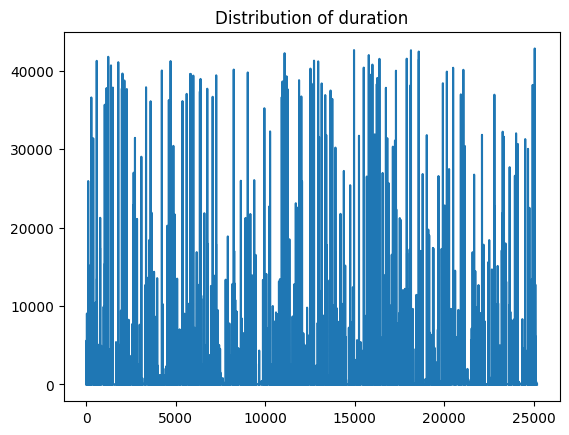

In [ ]:
train.duration.plot(title='Distribution of duration')

<Axes: title={'center': 'Distribution of dst_bytes'}>

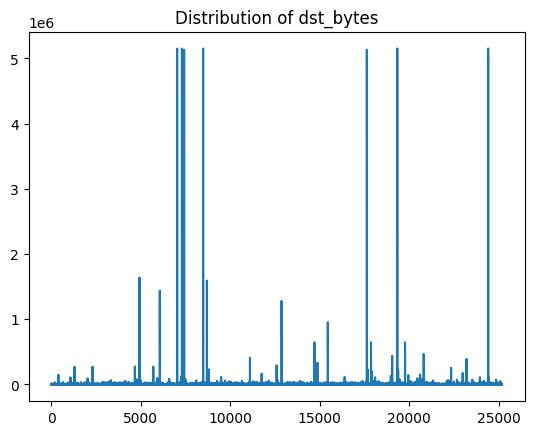

In [ ]:
train.dst_bytes.plot(title='Distribution of dst_bytes')

### Cleaning up the dataset


1.   Feature encoding
2.   Feature scaling



In [ ]:
## Feature encoding - label-encoding
labelEncoder = LabelEncoder()
train['flag_cat'] = labelEncoder.fit_transform(train['flag'])
#test['flag_cat'] = labelEncoder.fit_transform(test['flag'])
train['protocol_type_cat'] = labelEncoder.fit_transform(train['protocol_type'])
#test['protocol_type_cat'] = labelEncoder.fit_transform(test['protocol_type'])
train['service_cat'] = labelEncoder.fit_transform(train['service'])
#test['service_cat'] = labelEncoder.fit_transform(test['service'])

In [ ]:
train.drop(labels=["flag", "protocol_type", "service"], axis="columns", inplace=True)
#test.drop(labels=["flag", "protocol_type", "service"], axis="columns", inplace=True)

In [ ]:
y = train['class']
train.drop('class', axis='columns', inplace=True)

In [ ]:
y.value_counts()['anomaly']

11743

In [ ]:
X = train

In [ ]:
numerical_columns = ['srv_serror_rate', 'dst_host_serror_rate', 'dst_host_same_src_port_rate', 'rerror_rate',
                     'dst_host_srv_rerror_rate', 'srv_rerror_rate', 'serror_rate', 'srv_diff_host_rate', 'same_srv_rate',
                     'dst_host_same_srv_rate', 'dst_host_srv_serror_rate', 'dst_host_srv_diff_host_rate',
                     'dst_host_rerror_rate', 'dst_host_diff_srv_rate', 'diff_srv_rate']

In [ ]:
scaler = StandardScaler()
for col in numerical_columns:
  temp = np.array(X[col]).reshape(-1,1)
  temp_scaled = scaler.fit_transform(temp)
  X[col] = temp_scaled.flatten()

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   src_bytes                    25192 non-null  int64  
 2   dst_bytes                    25192 non-null  int64  
 3   land                         25192 non-null  int64  
 4   wrong_fragment               25192 non-null  int64  
 5   urgent                       25192 non-null  int64  
 6   hot                          25192 non-null  int64  
 7   num_failed_logins            25192 non-null  int64  
 8   logged_in                    25192 non-null  int64  
 9   num_compromised              25192 non-null  int64  
 10  root_shell                   25192 non-null  int64  
 11  su_attempted                 25192 non-null  int64  
 12  num_root                     25192 non-null  int64  
 13  num_file_creatio

Perform the Train-Test-Split on the entire dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random.randint(0,10000))

### Calculating feature importance and ranking

First attempt is a random Decision Tree Classifier, this did not give results in accordance with the paper (see below)

In [ ]:
FeatImportanceTree = DecisionTreeClassifier(criterion='gini', random_state=random.randint(0,10000))
FeatImportanceTree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=4696)

In [ ]:
importances = {}
importanceList = FeatImportanceTree.feature_importances_
for feat, value in enumerate(importanceList):
  importances[X_train.columns[feat]] = np.round(value, 5)
sort_importances = sorted(importances.items(), key=lambda k: k[1], reverse=True)
pprint.pprint(sort_importances)

[('src_bytes', 0.75404),
 ('protocol_type_cat', 0.0638),
 ('dst_host_srv_count', 0.049),
 ('dst_bytes', 0.02411),
 ('dst_host_srv_rerror_rate', 0.02407),
 ('hot', 0.02211),
 ('service_cat', 0.01162),
 ('logged_in', 0.01029),
 ('dst_host_same_srv_rate', 0.00823),
 ('dst_host_srv_diff_host_rate', 0.00818),
 ('dst_host_same_src_port_rate', 0.00534),
 ('duration', 0.00444),
 ('count', 0.00396),
 ('dst_host_rerror_rate', 0.0031),
 ('dst_host_diff_srv_rate', 0.00218),
 ('dst_host_srv_serror_rate', 0.00143),
 ('diff_srv_rate', 0.00116),
 ('dst_host_serror_rate', 0.00059),
 ('same_srv_rate', 0.00057),
 ('dst_host_count', 0.00053),
 ('num_root', 0.00033),
 ('is_guest_login', 0.0002),
 ('num_access_files', 0.00019),
 ('flag_cat', 0.00019),
 ('srv_count', 0.00015),
 ('rerror_rate', 0.0001),
 ('land', 9e-05),
 ('wrong_fragment', 0.0),
 ('urgent', 0.0),
 ('num_failed_logins', 0.0),
 ('num_compromised', 0.0),
 ('root_shell', 0.0),
 ('su_attempted', 0.0),
 ('num_file_creations', 0.0),
 ('num_shells',

second attempt is a Random Forest classifier (multiple decision trees in an ensemble)

In [ ]:
FeatImportanceForest = RandomForestClassifier(criterion='gini', random_state=random.randint(0,10000))
FeatImportanceForest.fit(X_train, y_train)

RandomForestClassifier(random_state=584)

In [ ]:
importanceList = {}
importanceList = FeatImportanceForest.feature_importances_
for feat, value in enumerate(importanceList):
  importances[X_train.columns[feat]] = np.round(value, 5)
sort_importances = sorted(importances.items(), key=lambda k: k[1], reverse=True)
pprint.pprint(sort_importances)

[('src_bytes', 0.15193),
 ('dst_bytes', 0.12097),
 ('flag_cat', 0.0943),
 ('same_srv_rate', 0.07517),
 ('diff_srv_rate', 0.06214),
 ('dst_host_srv_count', 0.05668),
 ('dst_host_same_srv_rate', 0.05548),
 ('logged_in', 0.05497),
 ('dst_host_diff_srv_rate', 0.04749),
 ('protocol_type_cat', 0.04018),
 ('count', 0.02749),
 ('service_cat', 0.02724),
 ('dst_host_same_src_port_rate', 0.02585),
 ('dst_host_srv_serror_rate', 0.02521),
 ('dst_host_srv_diff_host_rate', 0.02269),
 ('srv_count', 0.01766),
 ('dst_host_count', 0.01467),
 ('dst_host_serror_rate', 0.01124),
 ('serror_rate', 0.00999),
 ('hot', 0.00908),
 ('dst_host_rerror_rate', 0.00819),
 ('srv_serror_rate', 0.00719),
 ('dst_host_srv_rerror_rate', 0.00717),
 ('srv_rerror_rate', 0.00496),
 ('num_compromised', 0.00495),
 ('wrong_fragment', 0.00486),
 ('srv_diff_host_rate', 0.00397),
 ('duration', 0.00339),
 ('rerror_rate', 0.00249),
 ('is_guest_login', 0.00119),
 ('num_root', 0.00041),
 ('num_file_creations', 0.00026),
 ('num_failed_logi

The above results are closer to the paper feature importance scores, but still not an exact match.

In the paper the researchers chose all features with a value above $t=0.02$.

In [ ]:
#select important features
imp_feature_list = []
for feat in enumerate(sort_importances):
  if feat[1][1] > 0.02:
    imp_feature_list.append(feat[1][0])
pprint.pprint(imp_feature_list)

['src_bytes',
 'dst_bytes',
 'flag_cat',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'logged_in',
 'dst_host_diff_srv_rate',
 'protocol_type_cat',
 'count',
 'service_cat',
 'dst_host_same_src_port_rate',
 'dst_host_srv_serror_rate',
 'dst_host_srv_diff_host_rate']


We see that the amount of importance features equals varies and is not the same as in the research paper.

### Designing the decision tree

In [ ]:
IDT_DS_x = X_train[imp_feature_list]
IDTTree = DecisionTreeClassifier(criterion='gini', random_state=random.randint(0,10000))

In [ ]:
cross_val_score(IDTTree, IDT_DS_x, y_train, cv=10)

array([0.99355159, 0.99404762, 0.99454365, 0.99602978, 0.99602978,
       0.99602978, 0.99404467, 0.99454094, 0.99602978, 0.99404467])

In [ ]:
IDTForest = RandomForestClassifier(criterion='gini', random_state=random.randint(0,10000))
IDTForest.fit(IDT_DS_x, y_train)

RandomForestClassifier(random_state=9537)

### Experimental results

### IntruDTree

In [ ]:
y_pred = IDTForest.predict(X_test[imp_feature_list])
print("Accuracy of Random Forest:", accuracy_score(y_test, y_pred))
print("Precision of Random Forest:", precision_score(y_test, y_pred,pos_label='anomaly'))
print("Recall of Random Forest:", recall_score(y_test, y_pred,pos_label='anomaly'))
print("Fscore of Random Forest:", f1_score(y_test, y_pred,pos_label='anomaly'))

Accuracy of Random Forest: 0.9960309585235165
Precision of Random Forest: 0.9966029723991507
Recall of Random Forest: 0.9949130987706656
Fscore of Random Forest: 0.9957573186253712


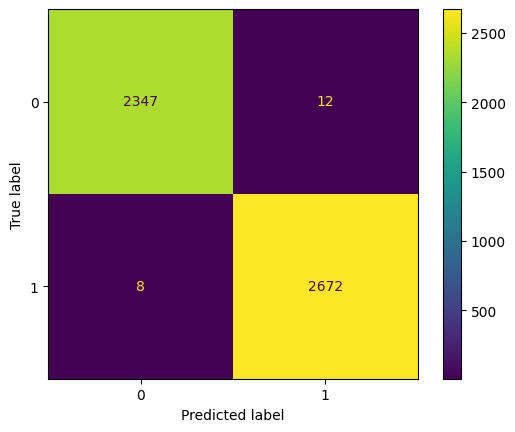

In [ ]:
confMatrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=confMatrix).plot()

In [ ]:
y_pred

array(['normal', 'anomaly', 'normal', ..., 'normal', 'normal', 'normal'],
      dtype=object)

In [ ]:
y_test = y_test.to_numpy()

In [ ]:
traffic = {'normal': 0, 'anomaly': 1}
y_test_int = np.vectorize(traffic.get)(y_test)
y_pred_int = np.vectorize(traffic.get)(y_pred)

In [ ]:
y_test_int

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
y_pred_int

array([0, 1, 0, ..., 0, 0, 0])

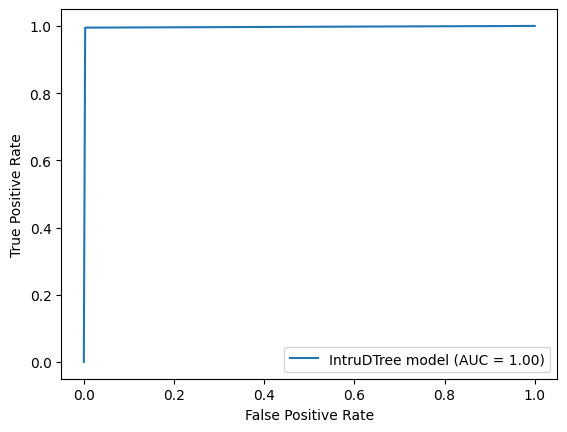

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_int, y_pred_int, pos_label=1)
roc_auc = auc(fpr,tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='IntruDTree model')
display.plot()
plt.show()

In [ ]:
print(roc_auc)

0.9959640120719


### Logistic Regression

Because of the lack of detailed hyperparameter settings in the paper, we chose the 'newton-cholesky' solver because our dataset contains label-encoded categorical features, some of those with rare categories. NC only incorporates L2 regularization and is proposed by the official scikit-learn documentary.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
lrCV = LogisticRegressionCV(cv=10, random_state=random.randint(0,10000), max_iter=1000, solver='newton-cholesky').fit(IDT_DS_x, y_train)
y_pred = lrCV.predict(X_test[imp_feature_list])

print("Accuracy of LR:", accuracy_score(y_test, y_pred))
print("Precision of LR:", precision_score(y_test, y_pred,pos_label='anomaly'))
print("Recall of LR:", recall_score(y_test, y_pred,pos_label='anomaly'))
print("Fscore of LR:", f1_score(y_test, y_pred,pos_label='anomaly'))

Accuracy of LR: 0.9440365151815836
Precision of LR: 0.9513255106475446
Recall of LR: 0.9279355659177617
Fscore of LR: 0.9394849785407726


The resulting accuracy (default returned score) is 0.94, this is the same score as given in the paper.

### SVM

In [ ]:
from sklearn.svm import SVC
svCV = SVC(random_state=random.randint(0,10000), gamma='auto')
svCV.fit(IDT_DS_x, y_train)
y_pred = svCV.predict(X_test[imp_feature_list])

print("Accuracy of SVM:", accuracy_score(y_test, y_pred))
print("Precision of SVM:", precision_score(y_test, y_pred,pos_label='anomaly'))
print("Recall of SVM:", recall_score(y_test, y_pred,pos_label='anomaly'))
print("Fscore of SVM", f1_score(y_test, y_pred,pos_label='anomaly'))


Accuracy of SVM: 0.9511807898392538
Precision of SVM: 0.9995271867612293
Recall of SVM: 0.8961424332344213
Fscore of SVM 0.9450156459544031


The resulting accuracy (defeault return score) is 0.95, this is only 0.01 less than the score given in the paper.

### NB
We use GaussianNB and will define the prior probabilities of each class by investigating the number of occurrences of each class in the training dataset

In [ ]:
np.array(np.unique(y_train, return_counts=True)).T

array([['anomaly', 9384],
       ['normal', 10769]], dtype=object)

In [ ]:
prior_anomaly = 9367/(9367+10786)
prior_normal = 10786/(9367+10786)

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB(priors=[prior_normal, prior_anomaly])
nb.fit(IDT_DS_x, y_train)
y_pred = nb.predict(X_test[imp_feature_list])

print("Accuracy of NB:", accuracy_score(y_test, y_pred))
print("Precision of NB:", precision_score(y_test, y_pred,pos_label='anomaly'))
print("Recall of NB:", recall_score(y_test, y_pred,pos_label='anomaly'))
print("Fscore of NB", f1_score(y_test, y_pred,pos_label='anomaly'))

Accuracy of NB: 0.8686247271283984
Precision of NB: 0.8762749445676274
Recall of NB: 0.837643069097075
Fscore of NB 0.8565236237537928


The results of the Gaussian Naive Bayes approach are way behind the described paper results.

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()
knc.fit(IDT_DS_x,y_train)
y_pred = knc.predict(X_test[imp_feature_list])

print("Accuracy of KNN:", accuracy_score(y_test, y_pred))
print("Precision of KNN:", precision_score(y_test, y_pred,pos_label='anomaly'))
print("Recall of KNN:", recall_score(y_test, y_pred,pos_label='anomaly'))
print("Fscore of KNN", f1_score(y_test, y_pred,pos_label='anomaly'))


Accuracy of KNN: 0.9910696566779122
Precision of KNN: 0.9877740303541316
Recall of KNN: 0.993217465027554
Fscore of KNN 0.9904882688649335


The score (0.99) seems to be higher than in the paper (0.94)